In [77]:
import requests
import json
from pprint import pp
import pandas as pd
import pyspark

In [78]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

import pandas as pd

In [79]:
url='https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
resposne=requests.get(url)
print(resposne)
r=resposne.json()

<Response [200]>


In [80]:
#df_loaneligible=pd.DataFrame(r)
df = pd.json_normalize(r)
pp(df)

    Application_ID  Gender Married Dependents     Education Self_Employed  \
0         LP001002    Male      No          0      Graduate            No   
1         LP001003    Male     Yes          1      Graduate            No   
2         LP001005    Male     Yes          0      Graduate           Yes   
3         LP001006    Male     Yes          0  Not Graduate            No   
4         LP001008    Male      No          0      Graduate            No   
..             ...     ...     ...        ...           ...           ...   
506       LP002978  Female      No          0      Graduate            No   
507       LP002979    Male     Yes         3+      Graduate            No   
508       LP002983    Male     Yes          1      Graduate            No   
509       LP002984    Male     Yes          2      Graduate            No   
510       LP002990  Female      No          0      Graduate           Yes   

     Credit_History Property_Area  Income Application_Status  
0           

In [81]:
spark = SparkSession.builder.appName("loan").getOrCreate()

In [82]:
sploanDF=spark.createDataFrame(df) 
sploanDF.printSchema()
sploanDF.show()


root
 |-- Application_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Application_Status: string (nullable = true)


c:\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
c:\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():



+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|

In [83]:
sploanDF.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [84]:
df_new1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .load()

df_new1.show(2)


+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001744|  Male|     No|         0|    Graduate|           No|             1|    Semiurban|   low|                 Y|
|      LP002714|  Male|     No|         1|Not Graduate|           No|             1|    Semiurban|   low|                 Y|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
only showing top 2 rows



In [87]:

query = "(SELECT self_employed, count(application_status), \
                (round(count(application_status)/(SELECT COUNT(Application_ID) FROM cdw_sapp_loan_application \
                WHERE application_status = 'Y')*100, 2) ) as Percent \
                FROM cdw_sapp_loan_application \
                WHERE Application_status = 'Y' \
                GROUP BY self_employed, application_status) as b"

sp_sql1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query) \
  .load()

sp_sql1.show()



+-------------+-------------------------+-------+
|self_employed|count(application_status)|Percent|
+-------------+-------------------------+-------+
|           No|                      301|  86.74|
|          Yes|                       46|  13.26|
+-------------+-------------------------+-------+



self_employed                 object
count(application_status)      int64
Percent                      float64
dtype: object


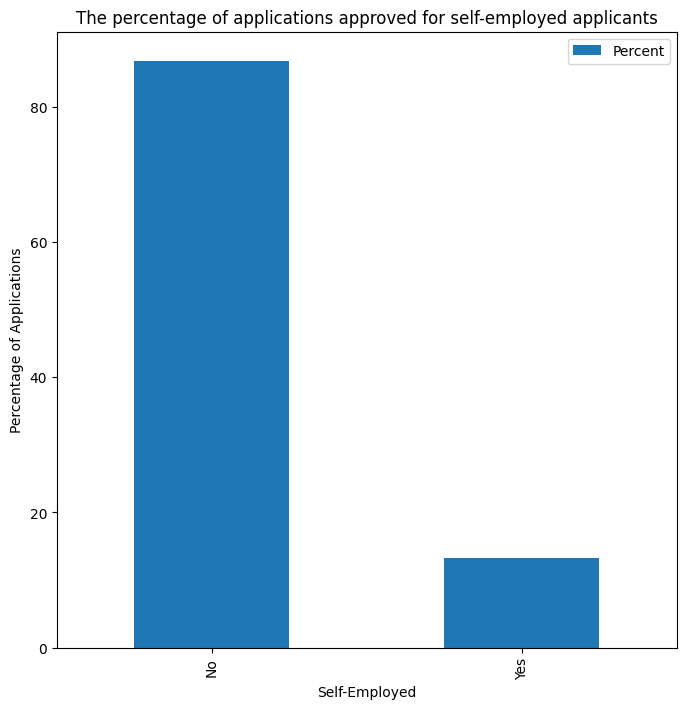

In [88]:
# import pandas as pd
import matplotlib.pyplot as plt

pd_sql1 = sp_sql1.toPandas()

# pd_sql1.reset_index(inplace=True)
pd_sql1['Percent'] = pd_sql1['Percent'].astype('float')
print(pd_sql1.dtypes)

pd_sql1.plot(kind='bar', x='self_employed', y='Percent', figsize=(8,8))
plt.title('The percentage of applications approved for self-employed applicants')
plt.xlabel('Self-Employed')
plt.ylabel('Percentage of Applications')
plt.show()


In [89]:
#Find the percentage of rejection for married male applicants.
#Note: Take a screenshot of the graph.

query2 = "(SELECT application_status, COUNT(application_status) AS count_applications, \
		(round(count(application_status)/(SELECT COUNT(*) FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' )*100,2)) AS Percent \
		FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' \
		GROUP BY application_status) as a"

sp_sql2 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query2) \
  .load()

sp_sql2.show()


+------------------+------------------+-------+
|application_status|count_applications|Percent|
+------------------+------------------+-------+
|                 N|                87|  28.43|
|                 Y|               219|  71.57|
+------------------+------------------+-------+



application_status     object
count_applications      int64
Percent               float64
dtype: object


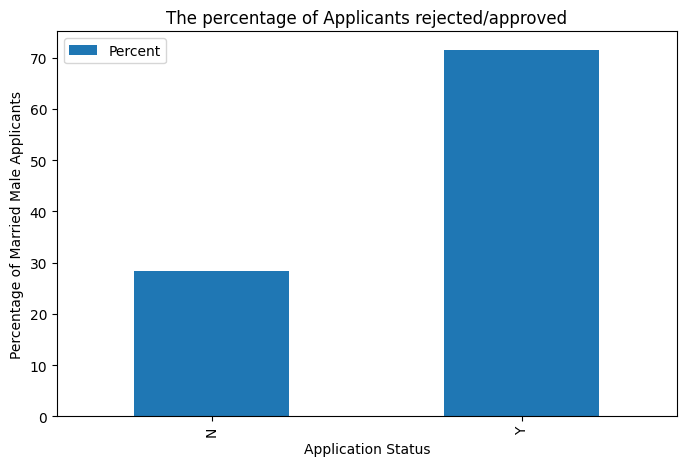

In [90]:
import matplotlib.pyplot as plt

pd_sql2 = sp_sql2.toPandas()

# pd_sql1.reset_index(inplace=True)
pd_sql2['Percent'] = pd_sql2['Percent'].astype('float')
print(pd_sql2.dtypes)

pd_sql2.plot(kind='bar', x='application_status', y='Percent', figsize=(8,5))
plt.title('The percentage of Applicants rejected/approved')
plt.xlabel('Application Status')
plt.ylabel('Percentage of Married Male Applicants')
plt.show()


Functional Requirements 5.3
Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph. 



In [92]:
query3 = "(SELECT month(timeid),MONTHNAME(timeid) AS Month, round(sum(TRANSACTION_value),2) AS Transaction_value \
            FROM cdw_sapp_credit_card \
            GROUP BY substr(timeid,1,6) \
            ORDER BY sum(TRANSACTION_value) DESC \
            LIMIT 3) as a"

sp_sql3 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query3) \
  .load()

sp_sql3.show()



+-------------+--------+-----------------+
|month(timeid)|   Month|Transaction_value|
+-------------+--------+-----------------+
|           10| October|        202583.89|
|            5|     May|        201310.26|
|           12|December|        201251.08|
+-------------+--------+-----------------+



month(timeid)          int32
Month                 object
Transaction_value    float64
dtype: object


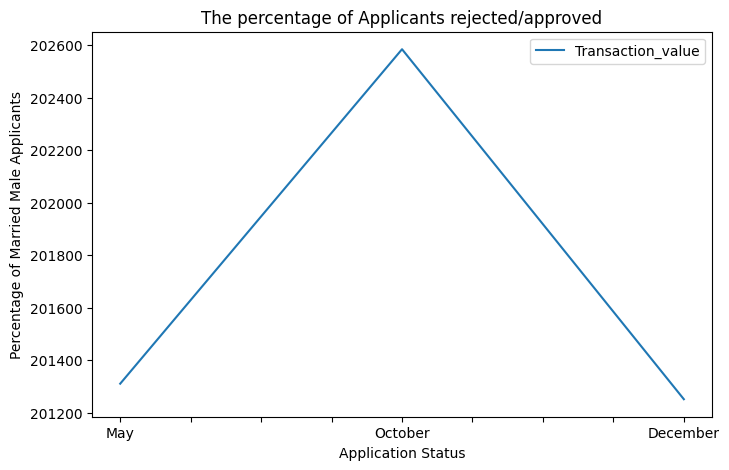

In [93]:
import matplotlib.pyplot as plt

pd_sql3 = sp_sql3.toPandas()
pd_sql3.sort_values(by='month(timeid)', inplace=True)

# pd_sql1.reset_index(inplace=True)
pd_sql3['Transaction_value'] = pd_sql3['Transaction_value'].astype('float')
print(pd_sql3.dtypes)

pd_sql3.plot(kind='line', x='Month', y='Transaction_value', figsize=(8,5))
plt.title('The percentage of Applicants rejected/approved')
plt.xlabel('Application Status')
plt.ylabel('Percentage of Married Male Applicants')
plt.show()


Functional Requirements 5.4
Find and plot which branch processed the highest total dollar value of healthcare transactions.
Note: Take a screenshot of the graph. 



In [94]:
query4 = "(SELECT branch_code, round(SUM(transaction_value),2) AS Total_Transaction_Value  \
            FROM cdw_sapp_credit_card \
            WHERE transaction_type = 'Healthcare'\
            group by branch_code \
            ORDER BY SUM(transaction_value) DESC \
            LIMIT 5) as a"

sp_sql4 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query4) \
  .load()

sp_sql4.show()


+-----------+-----------------------+
|branch_code|Total_Transaction_Value|
+-----------+-----------------------+
|         25|                4370.18|
|         60|                4072.04|
|         83|                4003.37|
|         36|                3823.87|
|        111|                3720.27|
+-----------+-----------------------+



branch_code                  int64
Total_Transaction_Value    float64
Transaction_value          float64
dtype: object


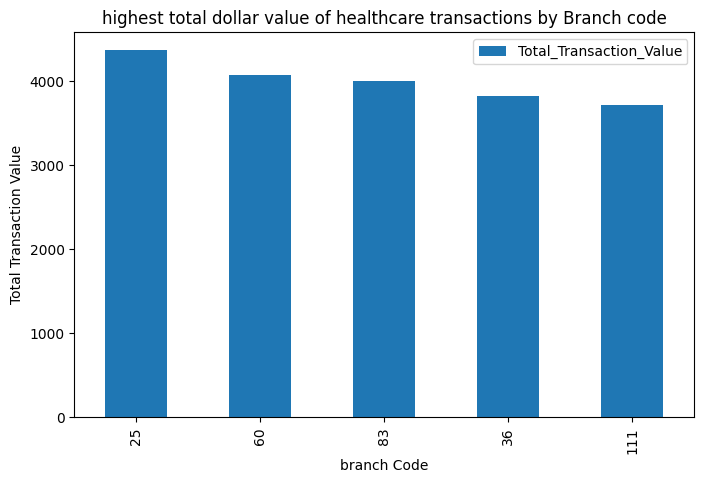

In [95]:
import matplotlib.pyplot as plt

pd_sql4 = sp_sql4.toPandas()
# pd_sql4.sort_values(by='month(timeid)', inplace=True)

# pd_sql1.reset_index(inplace=True)
pd_sql4['Transaction_value'] = pd_sql4['Total_Transaction_Value'].astype('float')
print(pd_sql4.dtypes)

pd_sql4.plot(kind='bar', x='branch_code', y='Total_Transaction_Value', figsize=(8,5))
plt.title('highest total dollar value of healthcare transactions by Branch code')
plt.ylabel('Total Transaction Value')
plt.xlabel('branch Code')
plt.show()
